In [1]:
import sys, os, argparse, numpy as np, logging, pandas as pd
from sklearn.externals import joblib
from copy import deepcopy
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# Load our modules
from constants import *
# this_dir = os.path.dirname(__file__)
# sys.path.append(os.path.join(this_dir, '../../src'))
sys.path.append('../../src')
from i_o import get_logger


In [3]:
args = argparse.Namespace()
args.feature_files=[
    'output-base/collins-roguev-sc-sp/features/sc-features-no_landmarks.pkl',
    'output-base/collins-roguev-sc-sp/features/sp-features-no_landmarks.pkl']
args.names = ['sc', 'sp']
args.lmk_feature_files=[
    'output-base/collins-roguev-sc-sp/features/sc-features-w_landmarks.pkl',
    'output-base/collins-roguev-sc-sp/features/sp-features-w_landmarks.pkl']
args.nozero = False
args.source_to_target = False


In [4]:
args.gi_files = ['../../data/gi/collins/sc/collins-sc-emap-gis-std.tsv', 
                '../../data/gi/roguev/sp/roguev-sp-emap-gis-std.tsv']
args.embedding_files = ['output-base/collins-roguev-sc-sp/embeddings/sc-HANDL-embedding.pkl',
                       'output-base/collins-roguev-sc-sp/embeddings/sp-HANDL-embedding.pkl']

In [5]:
obj = joblib.load(args.embedding_files[0])
embedding_S = obj.get('X')
nodes_S = obj.get('nodes')
landmarks_S = obj.get('landmarks')
n_nodes_S = len(nodes_S)
nodeToIndex_S = dict(zip(nodes_S, range(n_nodes_S)))

In [6]:
obj = joblib.load(args.embedding_files[1])
embedding_T = obj.get('X')
nodes_T = obj.get('nodes')
landmarks_T = obj.get('landmarks')
n_nodes_T = len(nodes_T)
nodeToIndex_T = dict(zip(nodes_T, range(n_nodes_T)))

In [7]:
embed_S_ctrd = sklearn.preprocessing.scale(embedding_S, with_std = False)
embed_T_ctrd = sklearn.preprocessing.scale(embedding_T, with_std = False)

In [8]:
land_embed_S_ctrd = embed_S_ctrd[[nodeToIndex_S[nd] for nd in landmarks_S]]
land_embed_T_ctrd = embed_T_ctrd[[nodeToIndex_T[nd] for nd in landmarks_T]]

## CCA and PLS

Best settings so far:
- PLSCanonical, 20 - 100 components, C = 50, f1 = .21
- CCA, 20 components, no scaling after transform, C = 1000, f1 = .22

In [9]:
from sklearn.cross_decomposition import CCA, PLSCanonical
cca = CCA(n_components=20)
cca.fit(land_embed_S_ctrd, land_embed_T_ctrd)

CCA(copy=True, max_iter=500, n_components=20, scale=True, tol=1e-06)

In [10]:
X_c, Y_c = cca.transform(land_embed_S_ctrd, land_embed_T_ctrd)

In [11]:
X_c = sklearn.preprocessing.scale(X_c)
Y_c = sklearn.preprocessing.scale(Y_c)

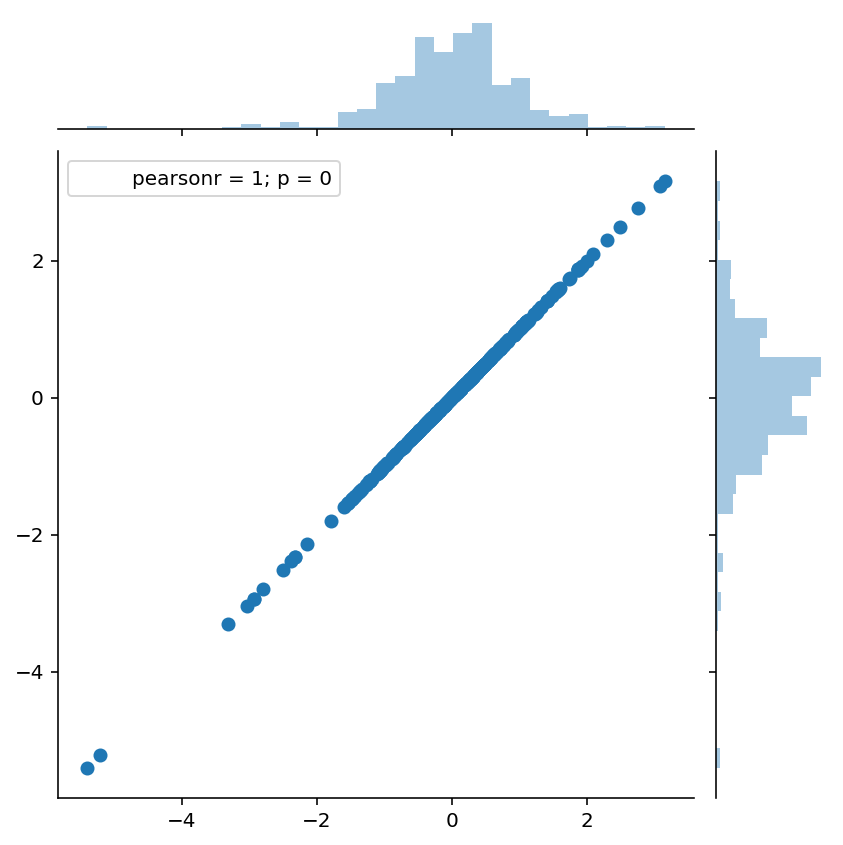

In [12]:
sns.jointplot(X_c[:,1], Y_c[:,1])

In [13]:
new_S, new_T = cca.transform(embed_S_ctrd, embed_T_ctrd)

In [14]:
joblib.dump(dict(X=new_S, nodes=nodes_S, 
                 landmarks=landmarks_S, weight=None), 'tmpfile1')
joblib.dump(dict(X=new_T, nodes=nodes_T, 
                 landmarks=landmarks_T, weight=None), 'tmpfile2')

['tmpfile2']

In [15]:
%run featurize_sls.py -ef 'tmpfile1' -gif {args.gi_files[0]} \
-o {args.lmk_feature_files[0]} --remove-landmarks
%run featurize_sls.py -ef 'tmpfile2' -gif {args.gi_files[1]} \
-o {args.lmk_feature_files[1]} --remove-landmarks

2018-03-13 13:46:20,954 featurize_sls.py INFO      : [Loading genetic interactions file]
2018-03-13 13:46:21,229 featurize_sls.py INFO      : - Loaded 131881 interactions (7210 SL and 124671 non-SL)
2018-03-13 13:46:21,230 featurize_sls.py INFO      : [Loading HANDL embedding]
2018-03-13 13:46:21,245 featurize_sls.py INFO      : - 5609 nodes
2018-03-13 13:46:21,246 featurize_sls.py INFO      : - 400 landmarks
2018-03-13 13:46:21,304 featurize_sls.py INFO      : - Restricting to 129385 pairs in the network
2018-03-13 13:46:21,352 featurize_sls.py INFO      : - Restricting to 110354 pairs in the network without landmarks
2018-03-13 13:46:23,879 featurize_sls.py INFO      : [Loading genetic interactions file]
2018-03-13 13:46:24,053 featurize_sls.py INFO      : - Loaded 103906 interactions (5605 SL and 98301 non-SL)
2018-03-13 13:46:24,054 featurize_sls.py INFO      : [Loading HANDL embedding]
2018-03-13 13:46:24,063 featurize_sls.py INFO      : - 1865 nodes
2018-03-13 13:46:24,063 featur

In [16]:
src_data = joblib.load(args.lmk_feature_files[0])
tgt_data = joblib.load(args.lmk_feature_files[1])

X_S, y_S = np.array(src_data.get('X')), src_data.get('y')
S_pairs, S_name = src_data.get('pairs'), args.names[0]
S_args = src_data.get('args')
X_T, y_T = np.array(tgt_data.get('X')), tgt_data.get('y')
T_pairs, T_name = tgt_data.get('pairs'), args.names[1]
T_args = tgt_data.get('args')

In [17]:
np.random.seed(3)

# We are going to use balanced training
T_sample = np.random.choice(np.where(y_S)[0], 1000)
F_sample = np.random.choice(np.where(~y_S)[0], 1000)
sample = np.concatenate((T_sample,F_sample))

print('X_S is {} by {} with {} positives'.format(X_S.shape[0], X_S.shape[1], np.sum(y_S)))
print('X_T is {} by {} with {} positives'.format(X_T.shape[0], X_T.shape[1], np.sum(y_T)))
# only use the first 100 features

XS = X_S[sample]
yS = y_S[sample]

XS_full = X_S
yS_full = y_S

# and imbalanced testing to match previous results
T_sample = np.random.choice(np.where(y_T)[0], 1000)
F_sample = np.random.choice(np.where(~y_T)[0], 1000)
sample = np.concatenate((T_sample,F_sample))

XT_full = X_T
yT_full = y_T

XT = X_T[sample]
yT = y_T[sample]

X_S is 110354 by 20 with 5708 positives
X_T is 18114 by 20 with 1961 positives


/Users/markcrovella/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


C: 0.01 training precision: 0.0 recall: 0.0 f1: 0.0
C: 0.01 testing precision: 0.20747663551401868 recall: 0.05660377358490566 f1: 0.0889423076923077
C: 0.1 training precision: 0.0 recall: 0.0 f1: 0.0
C: 0.1 testing precision: 0.20351390922401172 recall: 0.07088220295767465 f1: 0.10514372163388805
C: 1 training precision: 0.002628120893561104 recall: 0.000350385423966363 f1: 0.0006183335909723295
C: 1 testing precision: 0.2581699346405229 recall: 0.08057113717491075 f1: 0.12281383598911776
C: 10 training precision: 0.048426150121065374 recall: 0.02452697967764541 f1: 0.0325619258053262
C: 10 testing precision: 0.10977564102564102 recall: 0.27944926058133607 f1: 0.15762980008629368
C: 50 training precision: 0.034498577851179005 recall: 0.06587245970567625 f1: 0.04528210995363401
C: 50 testing precision: 0.10998660514957583 recall: 0.3768485466598674 f1: 0.17027649769585254
C: 75 training precision: 0.050777530942557915 recall: 0.22424667133847231 f1: 0.08280502005434079
C: 75 testing pr

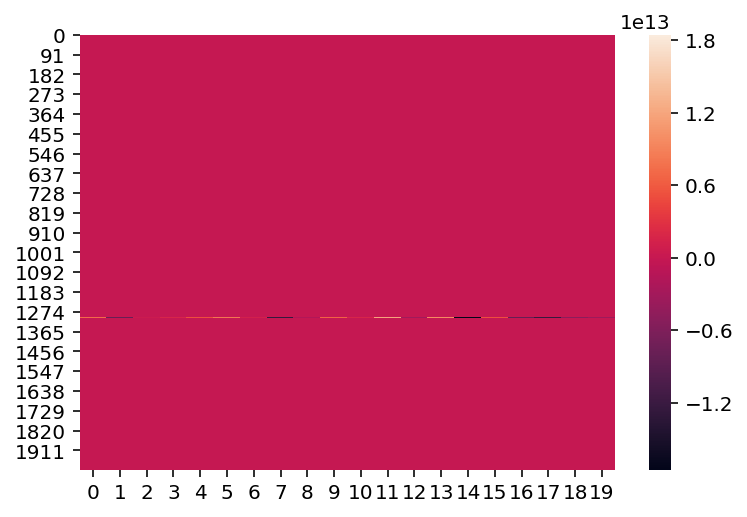

In [18]:
import sklearn.svm as svm
import sklearn
def test_svm(Xt, yt, Xv, yv):
    Cvals = [0.01, 0.1, 1, 10, 50, 75, 100, 1000, 10000, 100000]
    metrics = []
    clfs = []
    for C in Cvals:
        svc = svm.LinearSVC(C = C)
        svc.fit(Xt, yt)
        pred = svc.predict(Xt)
        prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(yt, pred)
        print('C: {} training precision: {} recall: {} f1: {}'.format(C, prec[1], rec[1], f1[1]))
        pred = svc.predict(Xv)
        prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(yv, pred)
        print('C: {} testing precision: {} recall: {} f1: {}'.format(C, prec[1], rec[1], f1[1]))

test_svm(XS_full, yS_full, XT_full, yT_full)
sns.heatmap(XS);

In [19]:
rps = np.sum(yS_full) / len(yS_full)
print('Random precision on source is {}'.format(rps))
print('Random f1 on source is {}'.format(2/(1/rps + 1)))
rpt = np.sum(yT_full) / len(yT_full)
print('Random precision on target is {}'.format(rpt))
print('Random f1 on target is {}'.format(2/(1/rpt + 1)))

Random precision on source is 0.05172445040506008
Random f1 on source is 0.09836122072685288
Random precision on target is 0.10825880534393287
Random f1 on target is 0.1953673723536737


__Note that there are some extreme outliers in the source data.  I am not sure why, but here we remove them.__

2018-03-13 13:50:37,266 legend.py       WARNING   : No handles with labels found to put in legend.


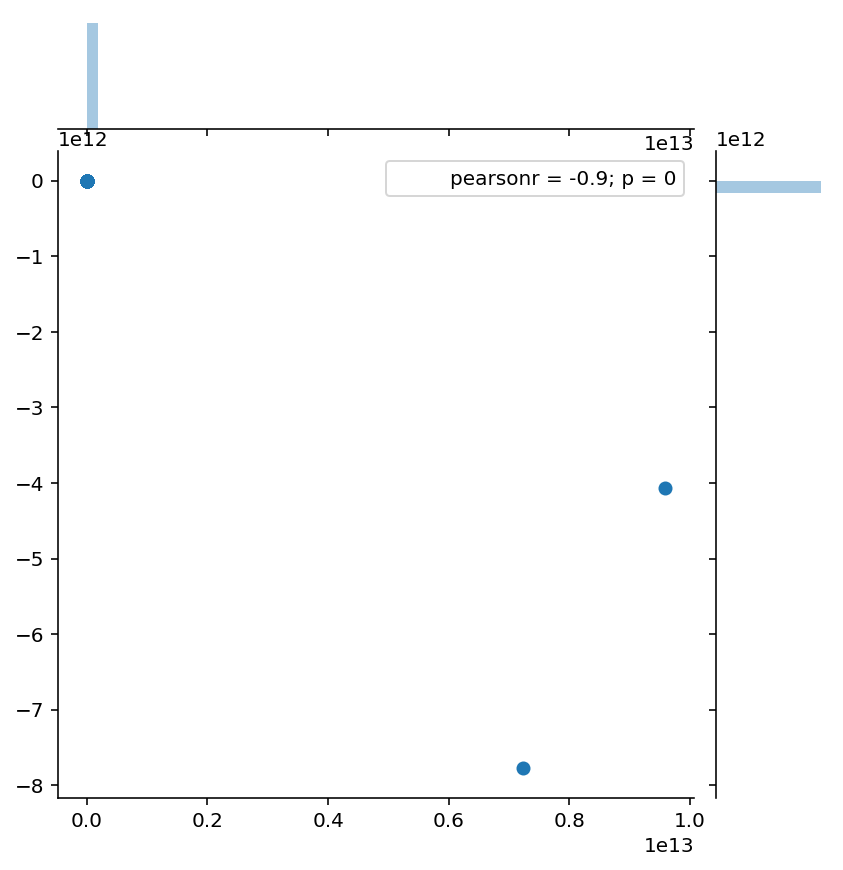

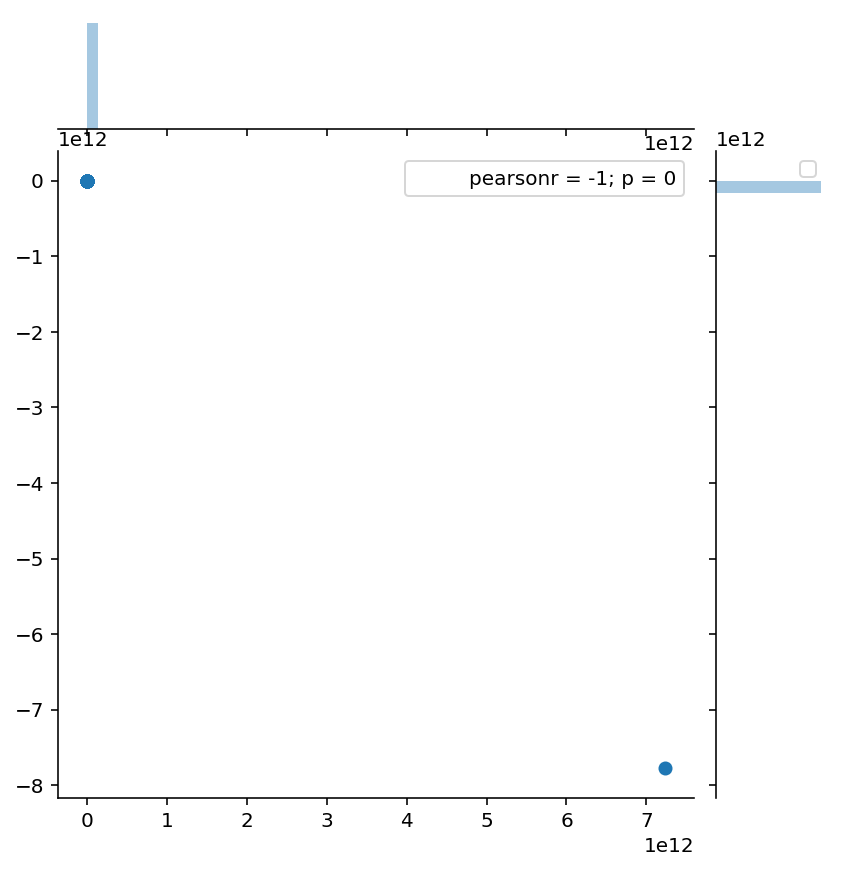

In [20]:
X_S_T = X_S[T_sample]
X_S_F = X_S[F_sample]
plt.figure()
sns.jointplot(X_S_T[:,0], X_S_T[:,1], label = 'T')
plt.figure()
sns.jointplot(X_S_F[:,0], X_S_F[:,1], label = 'F')
plt.legend(loc='best')

In [21]:
print(np.where(np.linalg.norm(X_S_T, axis=1) > 1000))
print(np.linalg.norm(X_S_T, axis=1)[np.where(np.linalg.norm(X_S_T, axis=1) > 1000)[0]])

(array([156, 988]),)
[3.53214792e+13 3.68977368e+13]


In [22]:
XS_full, yS_full, XT_full, yT_full

XS_norm = np.linalg.norm(XS_full, axis=1)
XT_norm = np.linalg.norm(XT_full, axis=1)

print(np.sum(XS_norm > 1000))
print(np.sum(XT_norm > 1000))

XS_trim = XS_full[XS_norm < 1000]
yS_trim = yS_full[XS_norm < 1000]

746
2266


Removing outliers does not have noticeably effect on classification performance.

In [23]:
svc = test_svm(XS_trim, yS_trim, XT_full, yT_full)

/Users/markcrovella/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


C: 0.01 training precision: 0.0 recall: 0.0 f1: 0.0
C: 0.01 testing precision: 0.20747663551401868 recall: 0.05660377358490566 f1: 0.0889423076923077
C: 0.1 training precision: 0.0 recall: 0.0 f1: 0.0
C: 0.1 testing precision: 0.20955882352941177 recall: 0.05813360530341662 f1: 0.09101796407185628
C: 1 training precision: 0.05013192612137203 recall: 0.0033298282509638976 f1: 0.006244864420706656
C: 1 testing precision: 0.21760797342192692 recall: 0.20040795512493625 f1: 0.20865410140695514
C: 10 training precision: 0.030744336569579287 recall: 0.0033298282509638976 f1: 0.006008855154965211
C: 10 testing precision: 0.14760263240363522 recall: 0.24018357980622132 f1: 0.18284161490683232
C: 50 training precision: 0.05902527075812274 recall: 0.057308096740273394 f1: 0.058154010314778584
C: 50 testing precision: 0.11093150131339664 recall: 0.2799592044875064 f1: 0.1589001447178003
C: 75 training precision: 0.04681282671451978 recall: 0.10515247108307045 f1: 0.06478432219402906
C: 75 testing

Here we visualize the new embedding to see if a classifier "should be able" to work

In [24]:
T_sample_trim = np.random.choice(np.where(yS_trim)[0], 1000)
F_sample_trim = np.random.choice(np.where(~yS_trim)[0], 1000)
X_S_T = XS_trim[T_sample_trim]
X_S_F = XS_trim[F_sample_trim]
T_sample = np.random.choice(np.where(yT)[0], 1000)
F_sample = np.random.choice(np.where(~yT)[0], 1000)
X_T_T = XT_full[T_sample]
X_T_F = XT_full[F_sample]

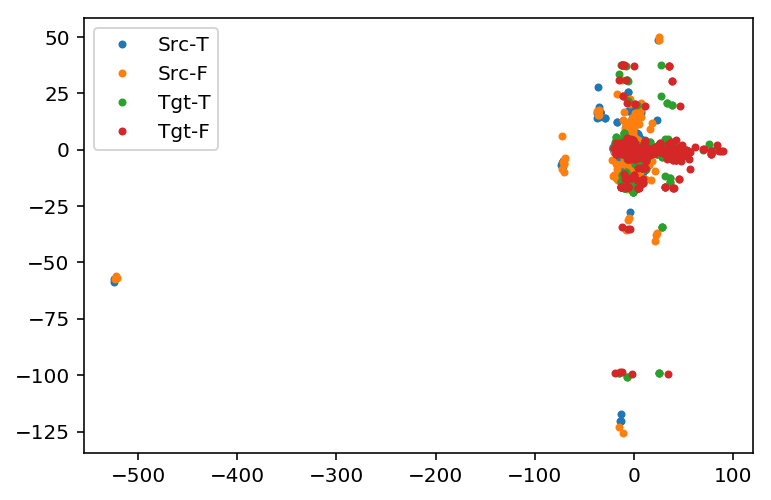

In [25]:
plt.plot(X_S_T[:,0], X_S_T[:,1], '.', label = 'Src-T')
plt.plot(X_S_F[:,0], X_S_F[:,1], '.', label = 'Src-F')
plt.plot(X_T_T[:,0], X_T_T[:,1], '.', label = 'Tgt-T')
plt.plot(X_T_F[:,0], X_T_F[:,1], '.', label = 'Tgt-F')
plt.legend(loc='best')

Nonetheless, when trained on target vectors, can do well.

In [26]:
def train_svm(Xt, yt):
    Cvals = [0.01, 0.1, 1, 10, 50, 75, 100, 1000, 10000, 100000]
    metrics = []
    clfs = []
    for C in Cvals:
        svc = svm.LinearSVC(C = C)
        svc.fit(Xt, yt)
        pred = svc.predict(Xt)
        prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(yt, pred)
        print('C: {} training precision: {} recall: {} f1: {}'.format(C, prec[1], rec[1], f1[1]))

train_svm(XT_full, yT_full)

C: 0.01 training precision: 0.04709141274238227 recall: 0.008669046404895462 f1: 0.014642549526270457
C: 0.1 training precision: 0.0603448275862069 recall: 0.014278429372768995 f1: 0.023092783505154636
C: 1 training precision: 0.12885906040268458 recall: 0.09790922998470168 f1: 0.11127209504491452
C: 10 training precision: 0.1279505127787726 recall: 0.4008159102498725 f1: 0.19397828232971373
C: 50 training precision: 0.07716371220020855 recall: 0.03773584905660377 f1: 0.05068493150684931
C: 75 training precision: 0.14116427195970968 recall: 0.48597654258031614 f1: 0.21877869605142333
C: 100 training precision: 0.11411004585243852 recall: 0.5583885772565018 f1: 0.18949554382625247
C: 1000 training precision: 0.08217168011738811 recall: 0.11422743498215196 f1: 0.09558352890975037
C: 10000 training precision: 0.12715285252960173 recall: 0.4818969913309536 f1: 0.20121366975407218
C: 100000 training precision: 0.11075612353567625 recall: 0.21213666496685366 f1: 0.1455308728354032


## CORAL 

In [39]:
%run featurize_sls.py -ef {args.embedding_files[0]} -gif {args.gi_files[0]} \
-o {args.lmk_feature_files[0]} --remove-landmarks
%run featurize_sls.py -ef {args.embedding_files[1]} -gif {args.gi_files[1]} \
-o {args.lmk_feature_files[1]} --remove-landmarks

2018-03-13 14:07:07,499 featurize_sls.py INFO      : [Loading genetic interactions file]
2018-03-13 14:07:07,745 featurize_sls.py INFO      : - Loaded 131881 interactions (7210 SL and 124671 non-SL)
2018-03-13 14:07:07,746 featurize_sls.py INFO      : [Loading HANDL embedding]
2018-03-13 14:07:07,924 featurize_sls.py INFO      : - 5609 nodes
2018-03-13 14:07:07,925 featurize_sls.py INFO      : - 400 landmarks
2018-03-13 14:07:07,981 featurize_sls.py INFO      : - Restricting to 129385 pairs in the network
2018-03-13 14:07:08,027 featurize_sls.py INFO      : - Restricting to 110354 pairs in the network without landmarks
2018-03-13 14:07:20,829 featurize_sls.py INFO      : [Loading genetic interactions file]
2018-03-13 14:07:20,956 featurize_sls.py INFO      : - Loaded 103906 interactions (5605 SL and 98301 non-SL)
2018-03-13 14:07:20,957 featurize_sls.py INFO      : [Loading HANDL embedding]
2018-03-13 14:07:21,031 featurize_sls.py INFO      : - 1865 nodes
2018-03-13 14:07:21,032 featur

In [40]:
src_data = joblib.load(args.lmk_feature_files[0])
tgt_data = joblib.load(args.lmk_feature_files[1])

X_S, y_S = np.array(src_data.get('X')), src_data.get('y')
S_pairs, S_name = src_data.get('pairs'), args.names[0]
S_args = src_data.get('args')
X_T, y_T = np.array(tgt_data.get('X')), tgt_data.get('y')
T_pairs, T_name = tgt_data.get('pairs'), args.names[1]
T_args = tgt_data.get('args')

We select a subset of features for experimenting with CORAL

In [51]:
np.random.seed(3)

first_feature = 1000
last_feature = 1100

# We are going to use balanced training
T_sample = np.random.choice(np.where(y_S)[0], 1000)
F_sample = np.random.choice(np.where(~y_S)[0], 1000)
sample = np.concatenate((T_sample,F_sample))

print('X_S is {} by {} with {} positives'.format(X_S.shape[0], X_S.shape[1], np.sum(y_S)))
print('X_T is {} by {} with {} positives'.format(X_T.shape[0], X_T.shape[1], np.sum(y_T)))

XS = X_S[sample,first_feature:last_feature]
yS = y_S[sample]

XS_full = X_S[:,first_feature:last_feature]
yS_full = y_S


T_sample = np.random.choice(np.where(y_T)[0], 1000)
F_sample = np.random.choice(np.where(~y_T)[0], 1000)
sample = np.concatenate((T_sample,F_sample))

XT_full = X_T[:,first_feature:last_feature]
yT_full = y_T

XT = X_T[sample,first_feature:last_feature]
yT = y_T[sample]

X_S is 110354 by 5609 with 5708 positives
X_T is 18114 by 5609 with 1961 positives


Checking to make sure covariance of all data is not different from that of our sample.

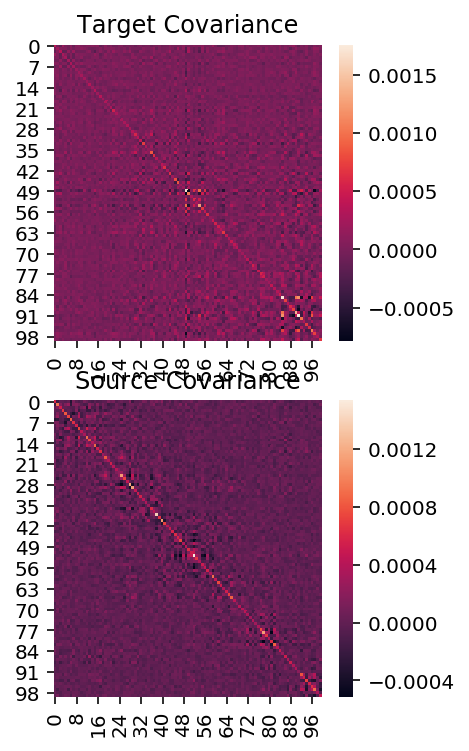

In [52]:
C1_centered = sklearn.preprocessing.scale(XS_full, with_std = False)
C2_centered = sklearn.preprocessing.scale(XT_full, with_std = False)

C1_cov = np.cov(XS_full.T)
C2_cov = np.cov(XT_full.T)

plt.figure(figsize=(3,6))
plt.subplot(2,1,1)
sns.heatmap(C2_cov)
plt.title('Target Covariance')
plt.subplot(2,1,2)
sns.heatmap(C1_cov)
plt.title('Source Covariance');

Checking rank because we don't want to try to transform a lower-rank matrix into a higher-rank one (can't be done).

In [53]:
print('Rank of C1_cov is {}'.format(np.linalg.matrix_rank(C1_cov)))
print('Rank of C2_cov is {}'.format(np.linalg.matrix_rank(C2_cov)))

Rank of C1_cov is 100
Rank of C2_cov is 100


First we look at covariances before transforming.

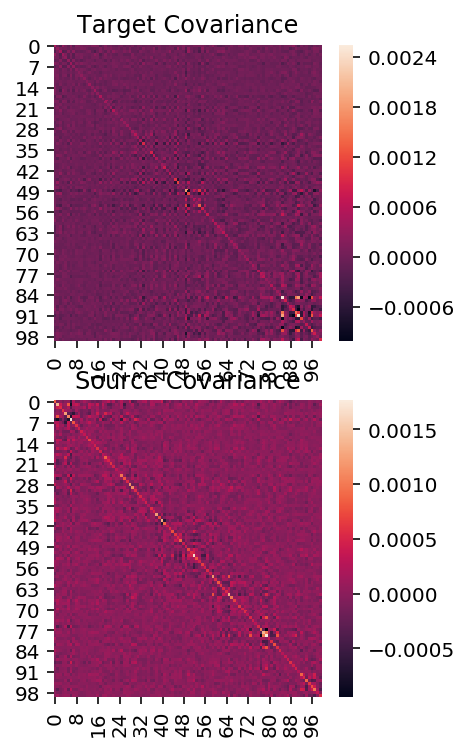

In [54]:
C1_centered = sklearn.preprocessing.scale(XS_full, with_std = False)
C2_centered = sklearn.preprocessing.scale(XT, with_std = False)
C2_full_centered = sklearn.preprocessing.scale(XT_full, with_std = False)

C1_cov = np.cov(XS.T)
C2_cov = np.cov(XT.T)

plt.figure(figsize=(3,6))
plt.subplot(2,1,1)
sns.heatmap(C2_cov)
plt.title('Target Covariance')
plt.subplot(2,1,2)
sns.heatmap(C1_cov)
plt.title('Source Covariance');

And look at the distributions of on-diagonal entries (variances) and off-diagonal entries (covariances).

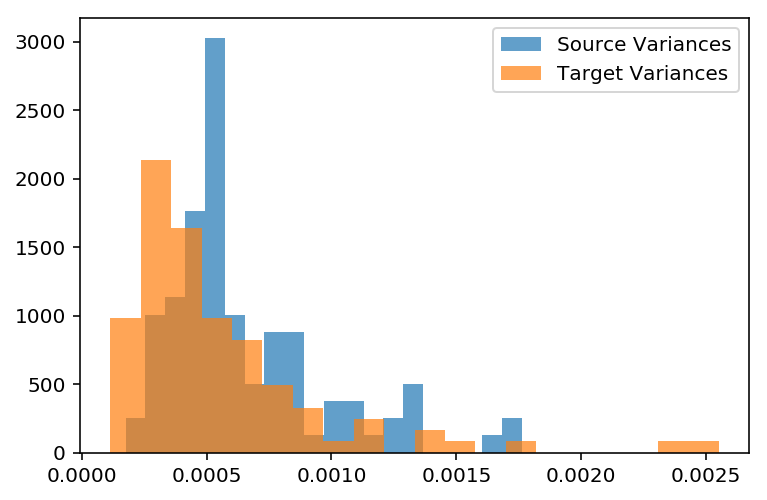

In [55]:
plt.hist(np.diag(C1_cov), density=True, label='Source Variances', bins=20, alpha=0.7)
plt.hist(np.diag(C2_cov), density=True, label='Target Variances', bins=20, alpha=0.7)
plt.legend(loc='best');

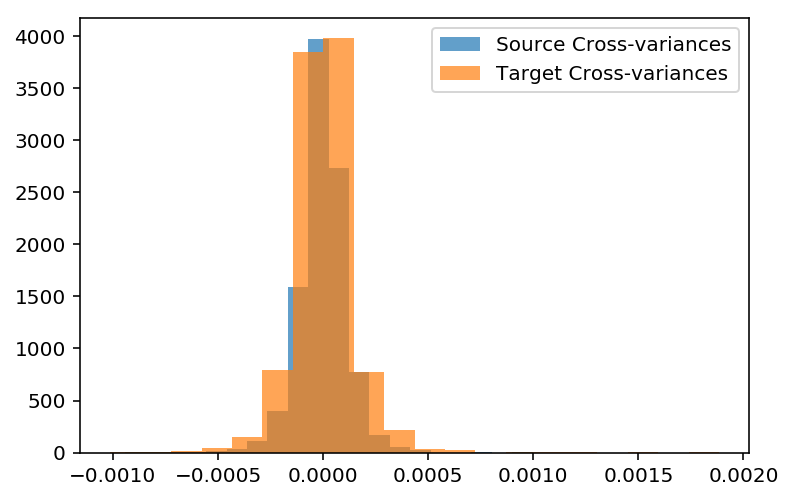

In [56]:
plt.hist(np.extract(1 - np.eye(C1_cov.shape[0]), C1_cov), label='Source Cross-variances', bins=20, alpha=0.7)
plt.hist(np.extract(1 - np.eye(C2_cov.shape[0]), C2_cov),label='Target Cross-variances', bins=20, alpha=0.7)
plt.legend(loc='best');

Now we apply CORAL

In [57]:
# regularize
lamb = 0.00001
CS = C1_cov + lamb * np.eye(*C1_cov.shape)
CT = C2_cov + lamb * np.eye(*C2_cov.shape)

source_to_target = True
if source_to_target:
    # this is the recommended approach in the coral paper
    CS_sqrt = np.real_if_close(sp.linalg.sqrtm(CS))
    DS = C1_centered @ np.linalg.pinv(CS_sqrt)
    NC_S = DS @ np.real_if_close(sp.linalg.sqrtm(CT))
else:
    # contrary to the coral paper we are 'fitting' the target distribution
    # into the source's distributional shape
    CT_sqrt = np.real_if_close(sp.linalg.sqrtm(CT))
    DT = C2_centered @ np.linalg.inv(CT_sqrt)
    NC_T = DT @ np.real_if_close(sp.linalg.sqrtm(CS))

Re-center the transformed C2.  Also look at new covariance matrices.

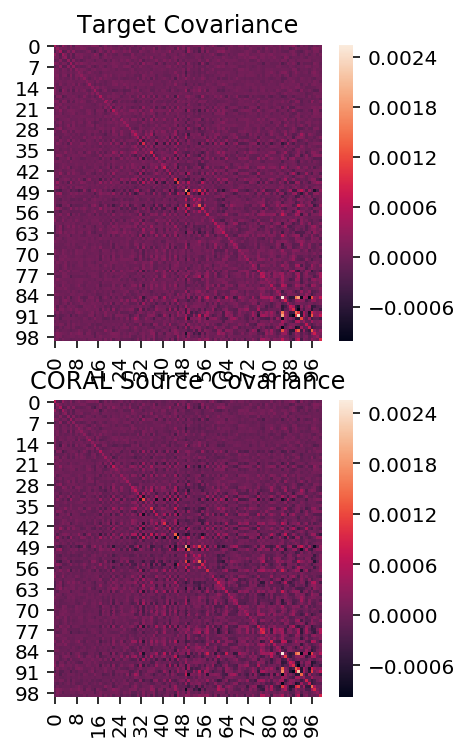

In [58]:
C1_Centered_CORAL = sklearn.preprocessing.scale(NC_S, with_std = False)
C1_cov_CORAL = np.cov(NC_S.T)
plt.figure(figsize=(3,6))
plt.subplot(2,1,1)
sns.heatmap(C2_cov)
plt.title('Target Covariance')
plt.subplot(2,1,2)
sns.heatmap(C1_cov_CORAL)
plt.title('CORAL Source Covariance');

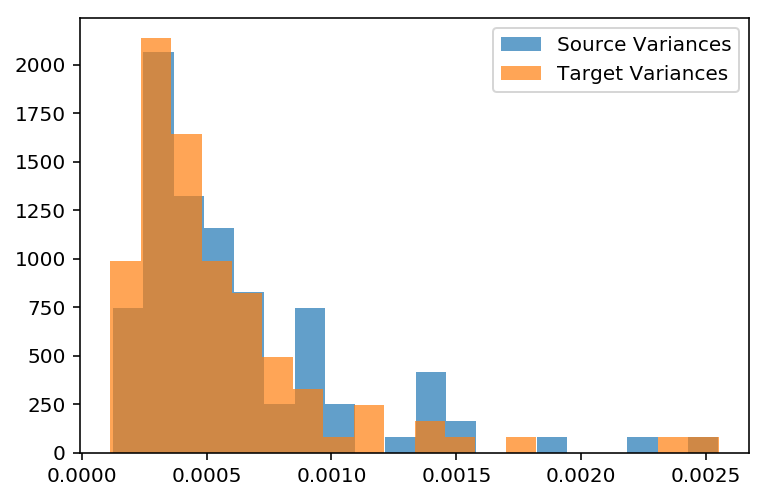

In [59]:
plt.hist(np.diag(C1_cov_CORAL), density=True, label='Source Variances', bins=20, alpha=0.7)
plt.hist(np.diag(C2_cov), density=True, label='Target Variances', bins=20, alpha=0.7)
plt.legend(loc='best');

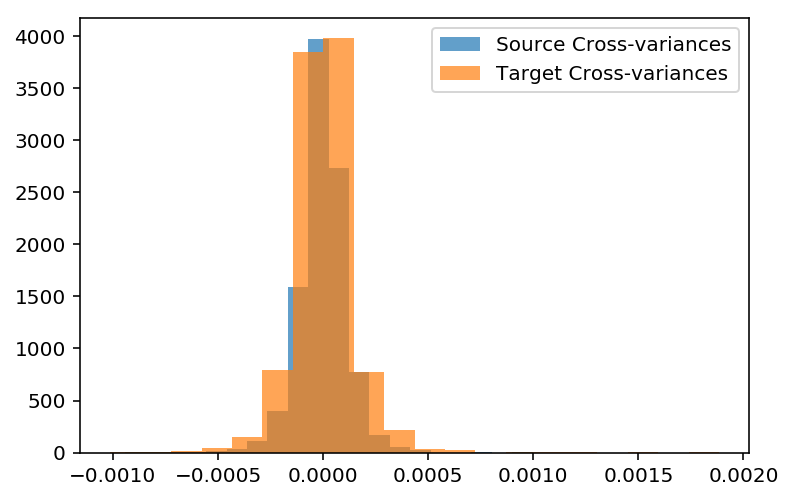

In [60]:
plt.hist(np.extract(1 - np.eye(C1_cov.shape[0]), C1_cov), label='Source Cross-variances', bins=20, alpha=0.7)
plt.hist(np.extract(1 - np.eye(C2_cov.shape[0]), C2_cov),label='Target Cross-variances', bins=20, alpha=0.7)
plt.legend(loc='best')

Now we see how the transformed source does on within-species and cross-species SL prediction.

In [ ]:
def train_svm(X, y):
    Cvals = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
    metrics = []
    clfs = []
    for C in Cvals:
        svc = svm.SVC(kernel='linear', C = C)
        svc.fit(X, y)
        pred = svc.predict(X)
        if 1 in pred:
            metrics.append(sklearn.metrics.f1_score(y, pred))
        else:
            metrics.append(0)
        clfs.append(svc)
    best = np.where(metrics == max(metrics))
    return clfs[best[0][0]]

svc = train_svm(C1_Centered_CORAL, yS_full)
print('C value for this data: {}'.format(svc.C))
svc.fit(C1_Centered_CORAL, yS)
pred_S = svc.predict(C1_Centered_CORAL)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(yS, pred_S)
print("SVM on CORALIZED source set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))
#
pred_T = svc.predict(C2_centered)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(yT, pred_T)
print("SVM on target set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))
#
pred_T = svc.predict(C2_full_centered)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(yT_full, pred_T)
print("SVM on test set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))